In [1]:
from pathlib import Path
from itertools import product
from typing import Union
from collections import namedtuple

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import extended_io as eio
import constants as const

In [2]:
Arguments = namedtuple('Arguments', ['clusters', 'fasta', 'sorfdb', 'cytoscape', 'output', 'tmp', 'threads'])
args = Arguments(clusters=Path('/vol/sorf/no_backup/db/sorfdb/raw/auto.cluster.tsv'), 
                 fasta=Path('/vol/sorf/no_backup/db/sorfdb/sprot.clustering.faa.gz'),
                 sorfdb=Path('/vol/sorf/no_backup/db/sorfdb/sorfdb.1.0.tsv'),
                 cytoscape=Path('/vol/sorf/no_backup/db/sorfdb/raw/srv.clustered.tsv'),
                 output=Path('/vol/sorf/no_backup/db/sorfdb/raw/'),
                 tmp=Path('/vol/sorf/no_backup/tmp/'),
                 threads=6)

uniref90_swissport = Path('/vol/sorf/no_backup/db/uniref90/swissprot.uniref90.faa.gz')
uniref90_uniprot_filtered = Path('/vol/sorf/no_backup/db/uniref90/uniprot.filtered.uniref90.faa.gz')
uniref90_uniprot_all = Path('/vol/sorf/no_backup/db/uniref90/uniprot.all.uniref90.faa.gz')
uniref100_swissport = Path('/vol/sorf/no_backup/db/uniref90/curated.faa.gz')
uniref100_uniprot_filtered = Path('/vol/sorf/no_backup/db/uniref90/evidence.faa.gz')
uniref100_uniprot_all = Path('/vol/sorf/no_backup/db/uniref90/predicted.faa.gz')

sprot_count_total =  pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
    ).collect().shape[0]
sprot_count_non_redundant = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
    ).unique().collect().shape[0]

In [3]:
def load_db(db_path: Path) -> pl.DataFrame:
    """
    Import the protein sequences and products from the (compressed) sorfdb.
    :param db_path: path to sorfdb file
    :return: Dataframe with proteins and products from sorfdb
    """
    compressed: bool = str(db_path).endswith('.gz')
    opener: Union[pl.read_csv, pl.scan_csv]
    if compressed:
        opener = pl.read_csv
    else:
        opener = pl.scan_csv

    db_df: Union[pl.DataFrame, pl.LazyFrame]
    db_df = opener(
        db_path,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product')
    ).filter(
        (pl.col('protein').str.lengths() <= const.HMM_MAX_SPROT_LENGTH) &
        (~pl.col('product').str.to_lowercase().is_in(pl.Series('hypothetical_product_names',
                                                               [term for term in const.HYPOTHETICAL_PRODUCT_NAMES])))
    ).with_columns(
        pl.col('product').apply(lambda x: x.split(' (')[0])  # Cut off reference ids of revised hypothetical products
    )

    if compressed:
        return db_df
    return db_df.collect()


def create_cluster_name(proteins: pl.Series, db_frame: pl.DataFrame) -> bytes:
    """
    Create a name of the given proteins based on a major vote on their protein product.
    :param proteins: proteins of a cluster
    :param db_frame: database with protein descriptions
    :return:
    """
    # one most common product
    name_frame = db_frame.lazy().filter(
        pl.col('protein').is_in(proteins)
    ).select(
        pl.col('product')
    ).groupby('product').count().filter(
        pl.col('count') == pl.col('count').max()
    ).collect()

    name: bytes
    if name_frame.shape[0] == 1:
        name = bytes(name_frame.to_series().to_list()[0], 'UTF-8')
    else:
        # one most common product in lower case
        name_frame = db_frame.lazy().filter(
            pl.col('protein').is_in(proteins)
        ).select(
            pl.col('product').str.to_lowercase()
        ).groupby('product').count().filter(
            pl.col('count') == pl.col('count').max()
        ).collect()
        if name_frame.shape[0] == 1:
            name = bytes(name_frame.to_series().to_list()[0], 'UTF-8')
        else:
            name = bytes('', 'UTF-8')
    return name


def read_mcl_cls(file: Path) -> pl.DataFrame:
    cluster_dict: dict[str, list[Union[str, int]]] = {
        'protein': [],
        'cluster': []
    }
    with open(file, 'r') as infile:
        for i, line in enumerate(infile):
            proteins: list[str] = line.strip().split()
            for protein, cls in product(proteins, [i]):
                cluster_dict['protein'].append(protein)
                cluster_dict['cluster'].append(cls)
    return pl.from_dict(cluster_dict)


def number_input_proteins(fasta: Path) -> int:
    total_proteins: int = 0
    for header, _ in eio.parse_fasta(fasta):
        total_proteins += 1
    return total_proteins


def get_products(clusters: pl.DataFrame, sorfdb: pl.DataFrame) -> pl.DataFrame:
    products_df: dict[str, list[Union[str, int]]] = {
        'cluster': [],
        'function': []
    }

    for cls, seqs in clusters.groupby('cluster'):
        products_df['cluster'].append(cls)
        products_df['function'].append(create_cluster_name(
            seqs.select(pl.col('protein')).to_series(),
            sorfdb
        ).decode('utf-8'))

    return pl.from_dict(products_df)

# sORFdb family statistic

In [4]:
total_proteins: int = number_input_proteins(args.fasta)
clusters: pl.DataFrame = read_mcl_cls(args.clusters)
# print(clusters)

protein_families: pl.DataFrame = clusters.groupby('cluster').agg(
        [pl.col('protein'),
         pl.col('cluster').count().alias('count')]
    ).filter(
        pl.col('count') >= 5
    ).select(
        pl.col('protein'),
        pl.col('cluster')
    ).explode(pl.col('protein'))

print('Number of input sequences:', total_proteins)
print('Number of clustered sequences:',
      clusters.shape[0])
print('Number of singletons:',
      clusters.groupby('cluster').count().filter(
          pl.col('count') == 1
      ).select(pl.col('cluster')).unique().shape[0])
print('Number of clusters:',
      clusters.groupby('cluster').count().filter(
          pl.col('count') >= 2
      ).select(pl.col('cluster')).unique().shape[0])
print('Number of families (>=5):',
      protein_families.select(pl.col('cluster')).unique().shape[0])

cluster_size: pl.DataFrame = clusters.groupby('cluster').count().filter(
    pl.col('count') >= 5
).select(
    pl.col('count')
).with_columns(
    pl.col('count').mean().alias('mean'),
    pl.col('count').median().alias('median'),
    pl.col('count').max().alias('max')
).drop('count').head(1)
print('Cluster size:')
print(cluster_size)

Number of input sequences: 309042
Number of clustered sequences: 272018
Number of singletons: 4037
Number of clusters: 16518
Number of families (>=5): 8884
Cluster size:
shape: (1, 3)
┌───────────┬────────┬─────┐
│ mean      ┆ median ┆ max │
│ ---       ┆ ---    ┆ --- │
│ f64       ┆ f64    ┆ u32 │
╞═══════════╪════════╪═════╡
│ 27.714881 ┆ 11.0   ┆ 363 │
└───────────┴────────┴─────┘


# Small protein family products

In [5]:
sorfdb_products_df: pl.DataFrame = load_db(args.sorfdb)
products_df: pl.DataFrame = get_products(
    protein_families,
    sorfdb_products_df
)

# All small protein family functions

In [6]:
products_df.groupby('function').count().sort('count', descending=True).filter(pl.col('function') != "").head(20)

function,count
str,u32
"""DUF3265 domain…",536
"""50S ribosomal …",533
"""50S ribosomal …",514
"""transposase""",251
"""50S ribosomal …",237
"""YjcZ family sp…",169
"""helix-turn-hel…",123
"""K(+)-transport…",83
"""entericidin A/…",67


In [7]:
print(products_df.filter(pl.col('function') == '').shape)

(86, 2)


In [8]:
singleton_products_df: pl.DataFrame = get_products(
    clusters.groupby('cluster').agg(
        [pl.col('protein'),
         pl.col('cluster').count().alias('count')]
    ).filter(
        pl.col('count') == 1
    ).select(
        pl.col('protein'),
        pl.col('cluster')
    ).explode(pl.col('protein')),
    sorfdb_products_df
)

In [9]:
print(singleton_products_df)

shape: (4_037, 2)
┌─────────┬───────────────────────────────────┐
│ cluster ┆ function                          │
│ ---     ┆ ---                               │
│ i64     ┆ str                               │
╞═════════╪═══════════════════════════════════╡
│ 18780   ┆ 50S ribosomal protein L34         │
│ 18992   ┆ 50S ribosomal protein L34         │
│ 13640   ┆ 50S ribosomal protein L36         │
│ 15388   ┆ sporulation histidine kinase inh… │
│ …       ┆ …                                 │
│ 13919   ┆ 50S ribosomal protein L36         │
│ 18619   ┆ 50S ribosomal protein L34         │
│ 11155   ┆ YHS domain-containing protein     │
│ 10983   ┆ FbpB family small basic protein   │
└─────────┴───────────────────────────────────┘


In [10]:
print(singleton_products_df.filter(pl.col('function') == '').shape)

(58, 2)


In [11]:
RIBOSOMAL_SHORT_NAMES: pl.Series = pl.Series('ribosomal', (
    "Ribosomal_L10",
    "Ribosomal_L11",
    "Ribosomal_L11_N",
    "Ribosomal_L12",
    "Ribosomal_L12_N",
    "Ribosomal_L14e",
    "Ribosomal_L17",
    "Ribosomal_L21e",
    "Ribosomal_L23",
    "Ribosomal_L23eN",
    "ribosomal_L24",
    "Ribosomal_L24e",
    "Ribosomal_L26",
    "Ribosomal_L30",
    "Ribosomal_L31",
    "Ribosomal_L31e",
    "Ribosomal_L33",
    "Ribosomal_L34",
    "Ribosomal_L34e",
    "Ribosomal_L35Ae",
    "Ribosomal_L35p",
    "Ribosomal_L36",
    "Ribosomal_L36e",
    "Ribosomal_L37e",
    "Ribosomal_L41",
    "Ribosomal_L44",
    "Ribosomal_L5",
    "Ribosomal_L6",
    "Ribosomal_L6e_N",
    "Ribosomal_L7Ae",
    "Ribosomal_L9_C",
    "Ribosomal_L9_N",
    "Ribosomal_S10",
    "Ribosomal_S12",
    "Ribosomal_S14",
    "Ribosomal_S15",
    "Ribosomal_S16",
    "Ribosomal_S17",
    "Ribosomal_S18",
    "Ribosomal_S19",
    "Ribosomal_S20p",
    "Ribosomal_S21",
    "Ribosomal_S21e",
    "Ribosomal_S24e",
    "Ribosomal_S27",
    "Ribosomal_S27e",
    "Ribosomal_S28e",
    "Ribosomal_S30",
    "Ribosomal_S3_C",
    "Ribosomal_S4",
    "Ribosomal_S5",
    "Ribosomal_S5_C",
    "Ribosomal_S6",
    "Ribosomal_TL5_C",
    "RPS31",
))

In [12]:
ribo_proteins: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product'),
        pl.col('pfam-hits')
    ).filter(
        pl.col('protein').str.lengths() <= const.HMM_MAX_SPROT_LENGTH
    ).with_columns(
        pl.col('pfam-hits').str.extract_all(r"'name': '\w+").list.eval(pl.element().str.lstrip("'name': '"))
    ).with_columns(
        pl.col('pfam-hits').list.eval(pl.element().is_in(RIBOSOMAL_SHORT_NAMES))
    ).with_columns(
        pl.col('pfam-hits').list.any()
    ).filter(
        (pl.col('pfam-hits') == True)
    ).unique().collect()

#  |
#        (pl.col('product').str.contains(
#            r"(\d{1,2}\w{1}|\wsu|small subunit).{1}ribosomal.{1}(subunit.{1})?protein.{1}(subunit.{1})?(\w{1}\d{1,2}|\w{3})"
#        ))

In [13]:
print(ribo_proteins)

shape: (60_523, 3)
┌───────────────────────────────────┬───────────────────────────────────┬───────────┐
│ protein                           ┆ product                           ┆ pfam-hits │
│ ---                               ┆ ---                               ┆ ---       │
│ str                               ┆ str                               ┆ bool      │
╞═══════════════════════════════════╪═══════════════════════════════════╪═══════════╡
│ MKRTFQPSVLKRNRSHGFRARMATKNGRQVLA… ┆ 50S ribosomal subunit protein L3… ┆ true      │
│ MRKIPLNCEACGNRNYNVPKQEGSATRLTLKK… ┆ 50S ribosomal protein L33         ┆ true      │
│ MKRTFQPNNRRRHMKSGFRVRMRTRAGRALIN… ┆ 50S ribosomal protein L34         ┆ true      │
│ MKRTFQPSILKRNRTHGFRVRMSRRQGRKILS… ┆ 50S ribosomal protein L34         ┆ true      │
│ …                                 ┆ …                                 ┆ …         │
│ MSKRTFQPNNRRRAKTHGFRLRMRTRAGRAIL… ┆ 50S ribosomal protein L34         ┆ true      │
│ MKILSSLKSAKHRHKECKVVKRKGRVFVICKS…

In [ ]:
pfam_ribo_classes: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('pfam-hits')
    ).filter(
        pl.col('protein').str.lengths() <= const.HMM_MAX_SPROT_LENGTH
    ).with_columns(
        pl.col('pfam-hits').str.extract_all(r"'name': '\w+").list.eval(pl.element().str.lstrip("'name': '"))
    ).filter(
        pl.col('pfam-hits').list.eval(pl.element().is_in(RIBOSOMAL_SHORT_NAMES)).list.any()
    ).with_columns(
        pl.col('pfam-hits').list.first().alias('pfam')
    ).select('protein', 'pfam').unique().collect()

# Cytoscape

In [ ]:
cytoscape_df: pl.DataFrame = pl.scan_csv(args.cytoscape, separator='\t').select(
    'query','subject', 'srv', 'q-autoclust'
).filter(
    (pl.col('query').is_in(protein_families.to_series())) &
    (pl.col('subject').is_in(protein_families.to_series()))
).collect()

In [ ]:
cytoscape_df.write_csv(args.output.joinpath('srv.clustered.filtered.tsv'), separator='\t')

In [ ]:
linked_nodes: set[str] = set(ribo_proteins.select('protein').to_series().to_list())
node_count: int = 0
while len(linked_nodes) > node_count:
    node_count = len(linked_nodes)
    subgraph_nodes = pl.Series('subnodes', tuple(linked_nodes))        
    subgraph = cytoscape_df.filter(
        (pl.col('query').is_in(subgraph_nodes)) |
        (pl.col('subject').is_in(subgraph_nodes))
    )
    linked_nodes = set(subgraph.select(pl.col('query')).unique().to_series().to_list() +
                       subgraph.select(pl.col('subject')).unique().to_series().to_list())
    
riboprotein_nodes = pl.Series('subnodes', tuple(linked_nodes))

In [ ]:
cytoscape_df.filter(
    (pl.col('query').is_in(riboprotein_nodes)) |
    (pl.col('subject').is_in(riboprotein_nodes))
).join(
    pfam_ribo_classes, 
    how='left', 
    left_on='query', 
    right_on='protein'
).unique().write_csv(args.output.joinpath('srv.clustered.ribo.classes.tsv'), separator='\t')

In [ ]:
cytoscape_df.filter(
    (pl.col('query').is_in(riboprotein_nodes)) |
    (pl.col('subject').is_in(riboprotein_nodes))
).join(
    pfam_ribo_classes, 
    how='left', 
    left_on='query', 
    right_on='protein'
).filter(pl.col('query') == 'MKVRSSVKRICENCKIIRRKGVVRVICTDPRHKQRQGK').select('pfam').unique().to_series().to_list()

['Ribosomal_L36']

In [ ]:
cytoscape_df.filter(
    ~(pl.col('query').is_in(riboprotein_nodes)) &
    ~(pl.col('subject').is_in(riboprotein_nodes))
).write_csv(args.output.joinpath('srv.clustered.non-ribo.tsv'), separator='\t')

In [ ]:
protein_families = protein_families.with_columns(
    pl.col('protein').is_in(
        riboprotein_nodes
    ).alias('ribo')
)

In [ ]:
families_plt_df: pd.DataFrame = protein_families.groupby('cluster').agg(
    [
        pl.col('cluster').count().alias('count'),
        pl.col('protein').str.lengths().mean().alias('length'),
        pl.col('ribo').any().alias('ribo'),
    ]
).to_pandas()
families_plt_df

,cluster,count,length,ribo
0,15556,9,43.111111,False
1,7500,5,41.600000,False
2,17184,23,44.260870,True
3,1028,45,32.133333,False
4,444,192,46.619792,False
...,...,...,...,...
8879,2767,6,47.166667,False
8880,17111,48,44.208333,True
8881,15123,106,42.915094,False
8882,2707,6,40.000000,False


# General Small protein functions
## All

In [ ]:
sprot_products: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product').str.to_lowercase()
    ).unique().groupby('product').count().sort('count', descending=True).head(20).collect()

In [ ]:
sprot_products_pfam: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('pfam-hits')
    ).drop_nulls().unique().select(
        pl.col('pfam-hits').str.extract_all(r"'name': '\w+").list.eval(pl.element().str.lstrip("'name': '")).alias('pfam')
    ).select(
        pl.col('pfam')
    ).explode('pfam').drop_nulls().select('pfam').groupby('pfam').count().sort('count', descending=True).head(20).collect()

In [ ]:
sprot_products

product,count
str,u32
"""helix-turn-hel…",86298
"""helix-turn-hel…",73168
"""transcriptiona…",66725
"""acyl carrier p…",66706
"""antitoxin""",61763
"""transposase""",51557
"""type ii toxin-…",41659
"""30s ribosomal …",37380
"""30s ribosomal …",35868


## Pfam

In [ ]:
sprot_products_pfam

pfam,count
str,u32
"""Bac_DNA_bindin…",97508
"""PhdYeFM_antito…",87664
"""HTH_3""",78709
"""PP""",74266
"""TatA_B_E""",64052
"""Ribosomal_L31""",62038
"""Ribosomal_S20p…",56771
"""Exonuc_VII_S""",54934
"""Ribosomal_S15""",54930


In [ ]:
sprots_with_pfam = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('pfam-hits')
    ).drop_nulls().filter(
        pl.col('pfam-hits') != '[]'
    ).unique().select(
        pl.col('protein')
    ).unique().collect().shape[0]

## Small proteins with Pfam annotations

In [ ]:
print(sprots_with_pfam)
print(sprot_count_non_redundant)
print(round(sprots_with_pfam/sprot_count_non_redundant*100, 2))

3754794
5073415
74.01


In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('plen'),
        pl.col('pfam-hits')
    ).unique().select(
        pl.col('protein'),
        pl.col('plen'),
        pl.col('pfam-hits').str.extract_all(r"'name': '\w+").list.eval(pl.element().str.lstrip("'name': '")).alias('pfam')
    ).select(
        pl.col('protein'),
        pl.col('plen'),
        pl.col('pfam')
    ).explode('pfam').unique().select(
        pl.col('plen').alias('len'),
        pl.col('pfam'),
        ~(pl.col('pfam').is_null().alias('hit')),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).collect().groupby(['hit', 'bin']).count().groupby('bin').apply(
        lambda x: x.select(pl.col('hit'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
    ).sort('bin', 'hit')

hit,bin,count
bool,i64,f64
false,10,100.0
false,20,92.85473
true,20,7.14527
false,30,64.182885
true,30,35.817115
false,40,55.806922
true,40,44.193078
false,50,48.948115
true,50,51.051885


## Small protein functions without ribosomal proteins

In [ ]:
sprot_products_no_ribo: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product').str.to_lowercase()
    ).filter(
        ~(pl.col('protein').is_in(ribo_proteins.select('protein').to_series())) &
        ~(pl.col('product').str.contains(r"(\d{1,2}\w{1}|\wsu|small subunit).{1}ribosomal.{1}(subunit.{1})?protein.{1}(subunit.{1})?(\w{1}\d{1,2}|\w{3})"))
    ).unique().groupby('product').count().sort('count', descending=True).head(20).collect()

In [ ]:
sprot_products_no_ribo.write_csv('/vol/sorf/no_backup/tmp/sprot_products.tsv', separator='\t')

In [74]:
sprot_products_no_ribo.select(pl.col('product'), pl.col('count'))

product,count
str,u32
"""helix-turn-hel…",86298
"""helix-turn-hel…",73168
"""transcriptiona…",66725
"""acyl carrier p…",66706
"""antitoxin""",61763
"""transposase""",51557
"""type ii toxin-…",41659
"""dna-binding pr…",35427
"""cold-shock pro…",33735


## Small protein Pfam functions without ribosomal proteins

In [ ]:
sprot_products_pfam.filter(
    ~(pl.col('pfam').is_in(RIBOSOMAL_SHORT_NAMES))
)

pfam,count
str,u32
"""Bac_DNA_bindin…",97508
"""PhdYeFM_antito…",87664
"""HTH_3""",78709
"""PP""",74266
"""TatA_B_E""",64052
"""Exonuc_VII_S""",54934
"""ATP""",54058
"""Cpn10""",53240
"""ThiS""",52985


## Small protein (<50AA) functions

In [ ]:
sprot_products_50: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product').str.to_lowercase()
    ).filter(
        pl.col('protein').str.lengths() <= 50
    ).unique().groupby('product').count().sort('count', descending=True).head(20).collect()

In [ ]:
sprot_products_50

product,count
str,u32
"""50s ribosomal …",19439
"""50s ribosomal …",17901
"""duf3265 domain…",17129
"""hypothetical p…",10793
"""50s ribosomal …",9198
"""transposase""",6221
"""yjcz family sp…",4277
"""entericidin a/…",3356
"""k(+)-transport…",3286


## Small protein (<50AA) functions without ribosomal proteins

In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('product').str.to_lowercase()
    ).filter(
        (pl.col('protein').str.lengths() <= 50) &
        ~(pl.col('protein').is_in(ribo_proteins.select('protein').to_series())) &
        ~(pl.col('product').str.contains(r"(\d{1,2}\w{1}|\wsu|small subunit).{1}ribosomal.{1}(subunit.{1})?protein.{1}(subunit.{1})?(\w{1}\d{1,2}|\w{3})"))
    ).unique().groupby('product').count().sort('count', descending=True).head(20).collect().to_series().to_list()

['duf3265 domain-containing protein',
 'hypothetical protein',
 'transposase',
 'yjcz family sporulation protein',
 'entericidin a/b family lipoprotein',
 'k(+)-transporting atpase subunit f',
 'helix-turn-helix domain-containing protein',
 'sporulation protein yjcz',
 'lmo0937 family membrane protein',
 'cytochrome bd-i oxidase subunit cydx',
 'duf2256 domain-containing protein',
 'coenzyme pqq synthesis protein a',
 'membrane protein',
 'potassium-transporting atpase subunit f',
 'feob-associated cys-rich membrane protein',
 'transcriptional regulator',
 'cyclic lactone autoinducer peptide',
 'gpe family phage tail protein',
 'duf1127 domain-containing protein',
 'xkdx family protein']

In [ ]:
pfam_ribo_classes: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('pfam-hits')
    ).filter(
        pl.col('protein').str.lengths() <= const.HMM_MAX_SPROT_LENGTH
    ).with_columns(
        pl.col('pfam-hits').str.extract_all(r"'name': '\w+").list.eval(pl.element().str.lstrip("'name': '"))
    ).filter(
        pl.col('pfam-hits').list.eval(pl.element().is_in(RIBOSOMAL_SHORT_NAMES)).list.any()
    ).with_columns(
        pl.col('pfam-hits').list.first().alias('pfam')
    ).select('protein', 'pfam').collect()

# Plots

In [ ]:
sns.set(font_scale=1.0) # 1.2
sns.set_style('ticks')

## Small protein family distribution

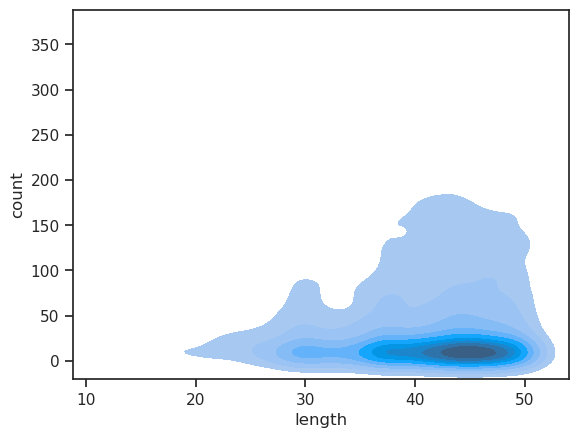

In [ ]:
ax_kde = sns.kdeplot(data=families_plt_df, 
                         x="length", y="count",
                         fill=True, color=sns.color_palette('colorblind')[0])


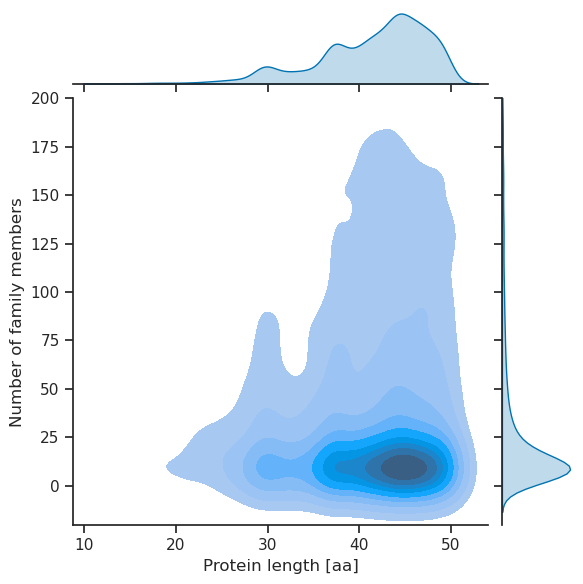

In [75]:
plt.close()
ax_joint = sns.jointplot(data=families_plt_df, 
                         x="length", y="count", kind='kde', 
                         fill=True, ylim=(ax_kde.get_ylim()[0],200), color=sns.color_palette('colorblind')[0])

ax_joint.set_axis_labels(xlabel='Protein length [aa]', ylabel='Number of family members')
#plt.yscale('log')
plt.gcf().savefig(str(args.output.joinpath('sprot_family_dist.pdf')), dpi=600)

In [ ]:
def fasta_faa_length(file) -> np.ndarray:
    faa_length = []
    for header, seq in eio.parse_fasta(file):
        faa_length.append(len(seq))
    return np.array(faa_length)

def unique_fasta_faa_length(file) -> np.ndarray:
    prots = set()
    faa_length = []
    for header, seq in eio.parse_fasta(file):
        if seq not in prots:
            faa_length.append(len(seq))
            prots.add(seq)
    return np.array(faa_length)

## Small protein length

In [ ]:
def combined_protein_length_plot(all_aa: np.ndarray, unique_sorf: np.ndarray, unique_aa: np.ndarray, 
                                 swissprot: np.ndarray, uniprot_filtered: np.ndarray, uniport_all: np.ndarray, 
                                 out_path: Path, group: str = '', file_name: str = 'sorfdb_length.pdf'):
    #sns.set_style('darkgrid')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_dpi(600.0)
    plt.yscale('log')
    sns.despine()

    hist_sorfdb = sns.histplot(ax=ax1, data=all_aa, discrete=True, label='Total small proteins', color=sns.color_palette('colorblind')[0])
    hist_sorfdb = sns.histplot(ax=ax1, data=np.divide(np.subtract(unique_sorf, 3.0), 3.0), discrete=True, label='Non-redundant sORFs', color=sns.color_palette('colorblind')[1])
    hist_sorfdb = sns.histplot(ax=ax1, data=unique_aa, discrete=True, label='Non-redundant small proteins', color=sns.color_palette()[2])
    
    handles, labels = hist_sorfdb.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    hist_sorfdb.legend(*zip(*unique), fontsize='x-small' , loc='lower center', bbox_to_anchor=(.5, 1))  # , loc='best'  # , loc='lower center', bbox_to_anchor=(.5, 1)
    
    hist_uniprot = sns.histplot(ax=ax2, data=uniport_all, discrete=True, label='Predicted small proteins', color=sns.color_palette('colorblind')[3], legend=False)
    hist_uniprot = sns.histplot(ax=ax2, data=uniprot_filtered, discrete=True, label='Small proteins with evidence', color=sns.color_palette('colorblind')[9], legend=False)
    hist_uniprot = sns.histplot(ax=ax2, data=swissprot, discrete=True, label='Curated small proteins', color=sns.color_palette('colorblind')[4], legend=False)
    
    handles, labels = hist_uniprot.get_legend_handles_labels()
    unique = [(h, l.capitalize()) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    hist_uniprot.legend(*zip(*unique), fontsize='x-small' , loc='lower center', bbox_to_anchor=(.5, 1))  # , loc='upper left'
    
    hist_sorfdb.set(xlabel='Protein length [aa]', ylabel='Number of sequences')
    hist_uniprot.set(xlabel='Protein length [aa]', ylabel='Number of sequences')
    
    ax2.set_xlim(*ax1.get_xlim())

    ax1.set_title('sORFdb',y=1.3)
    ax2.set_title(f'UniRef {group}',y=1.3)
    plt.tight_layout()
    plt.show()
    f.savefig(str(out_path.joinpath(file_name)), dpi=600.0)

In [ ]:
sprot_len_total: np.ndarray = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein').str.lengths().alias('total'),
).collect().to_series().to_numpy()

unique_sorf_len: np.ndarray = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf').unique().str.lengths().alias('usorfs'),
).collect().to_series().to_numpy()

unique_sprot_len: np.ndarray = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('protein').unique().str.lengths().alias('usprots'),
).collect().to_series().to_numpy()

In [ ]:
uniref90_swissport_len = fasta_faa_length(uniref90_swissport)
uniref90_uniprot_filtered_len = fasta_faa_length(uniref90_uniprot_filtered)
uniref90_uniprot_all_len = fasta_faa_length(uniref90_uniprot_all)

In [ ]:
uniref100_swissport_len = fasta_faa_length(uniref100_swissport)
uniref100_uniprot_filtered_len = fasta_faa_length(uniref100_uniprot_filtered)
uniref100_uniprot_all_len = fasta_faa_length(uniref100_uniprot_all)

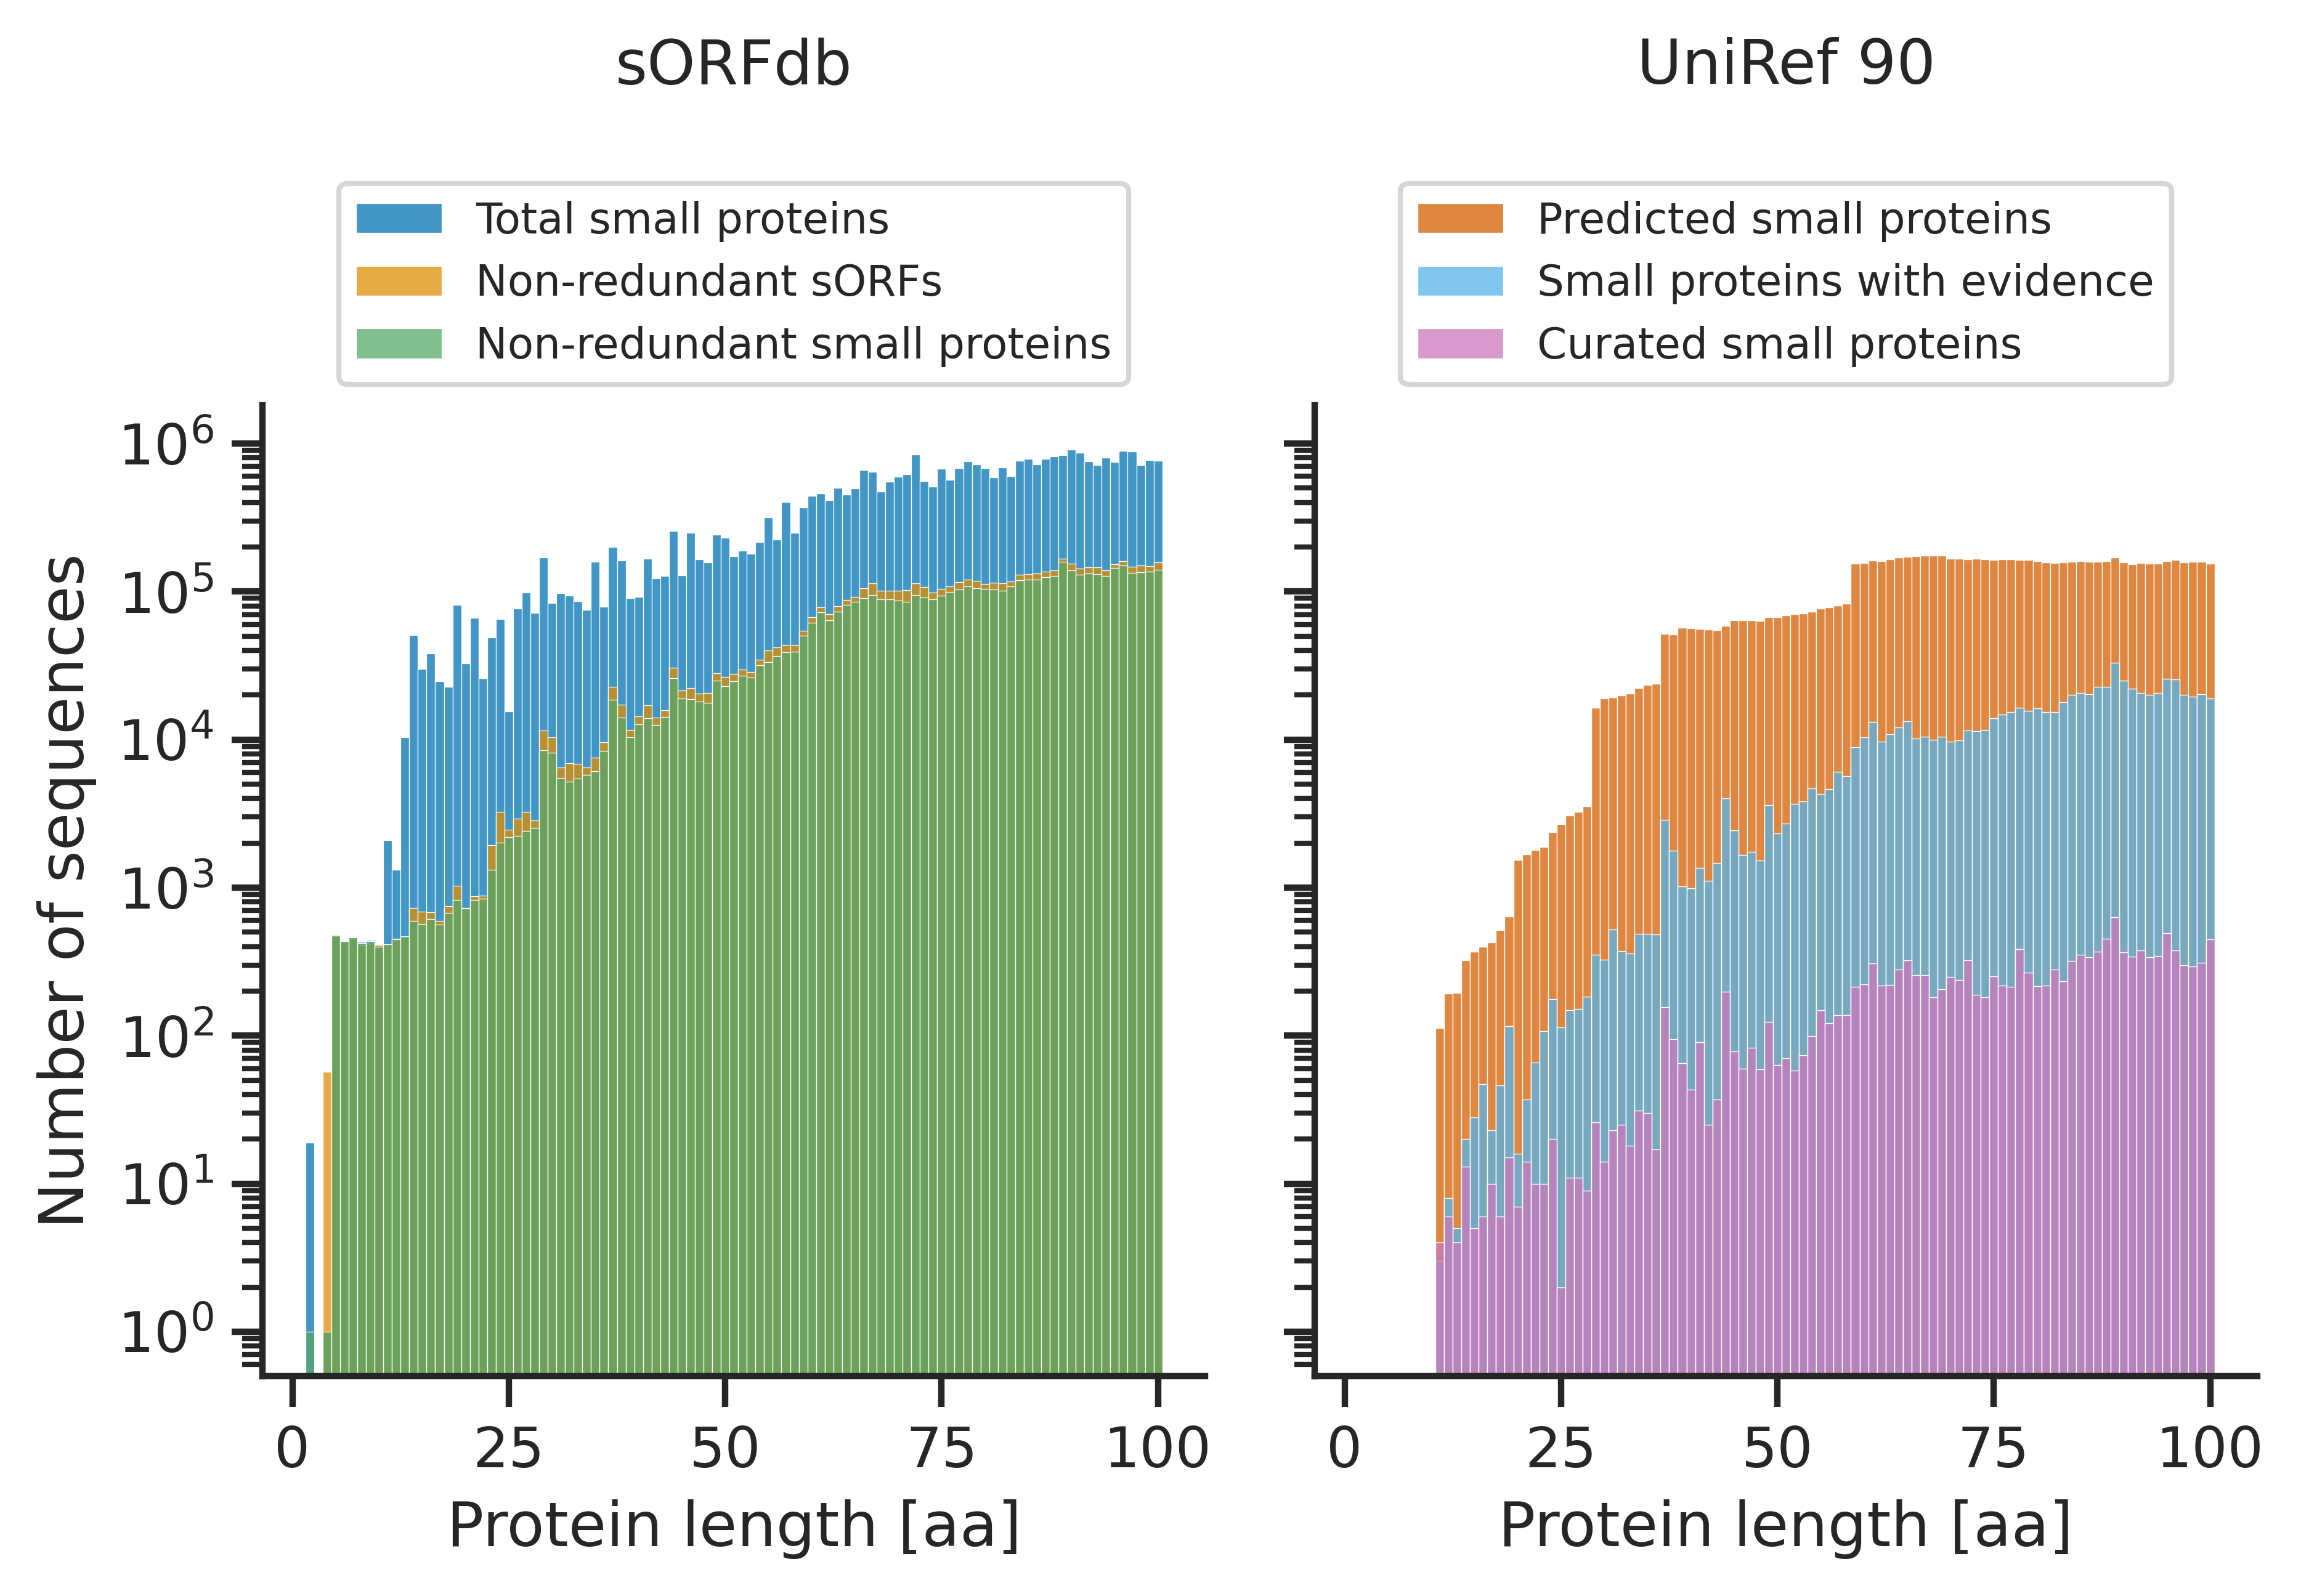

In [ ]:
combined_protein_length_plot(sprot_len_total, unique_sorf_len, unique_sprot_len, uniref90_swissport_len, uniref90_uniprot_filtered_len, uniref90_uniprot_all_len, args.output, group='90')

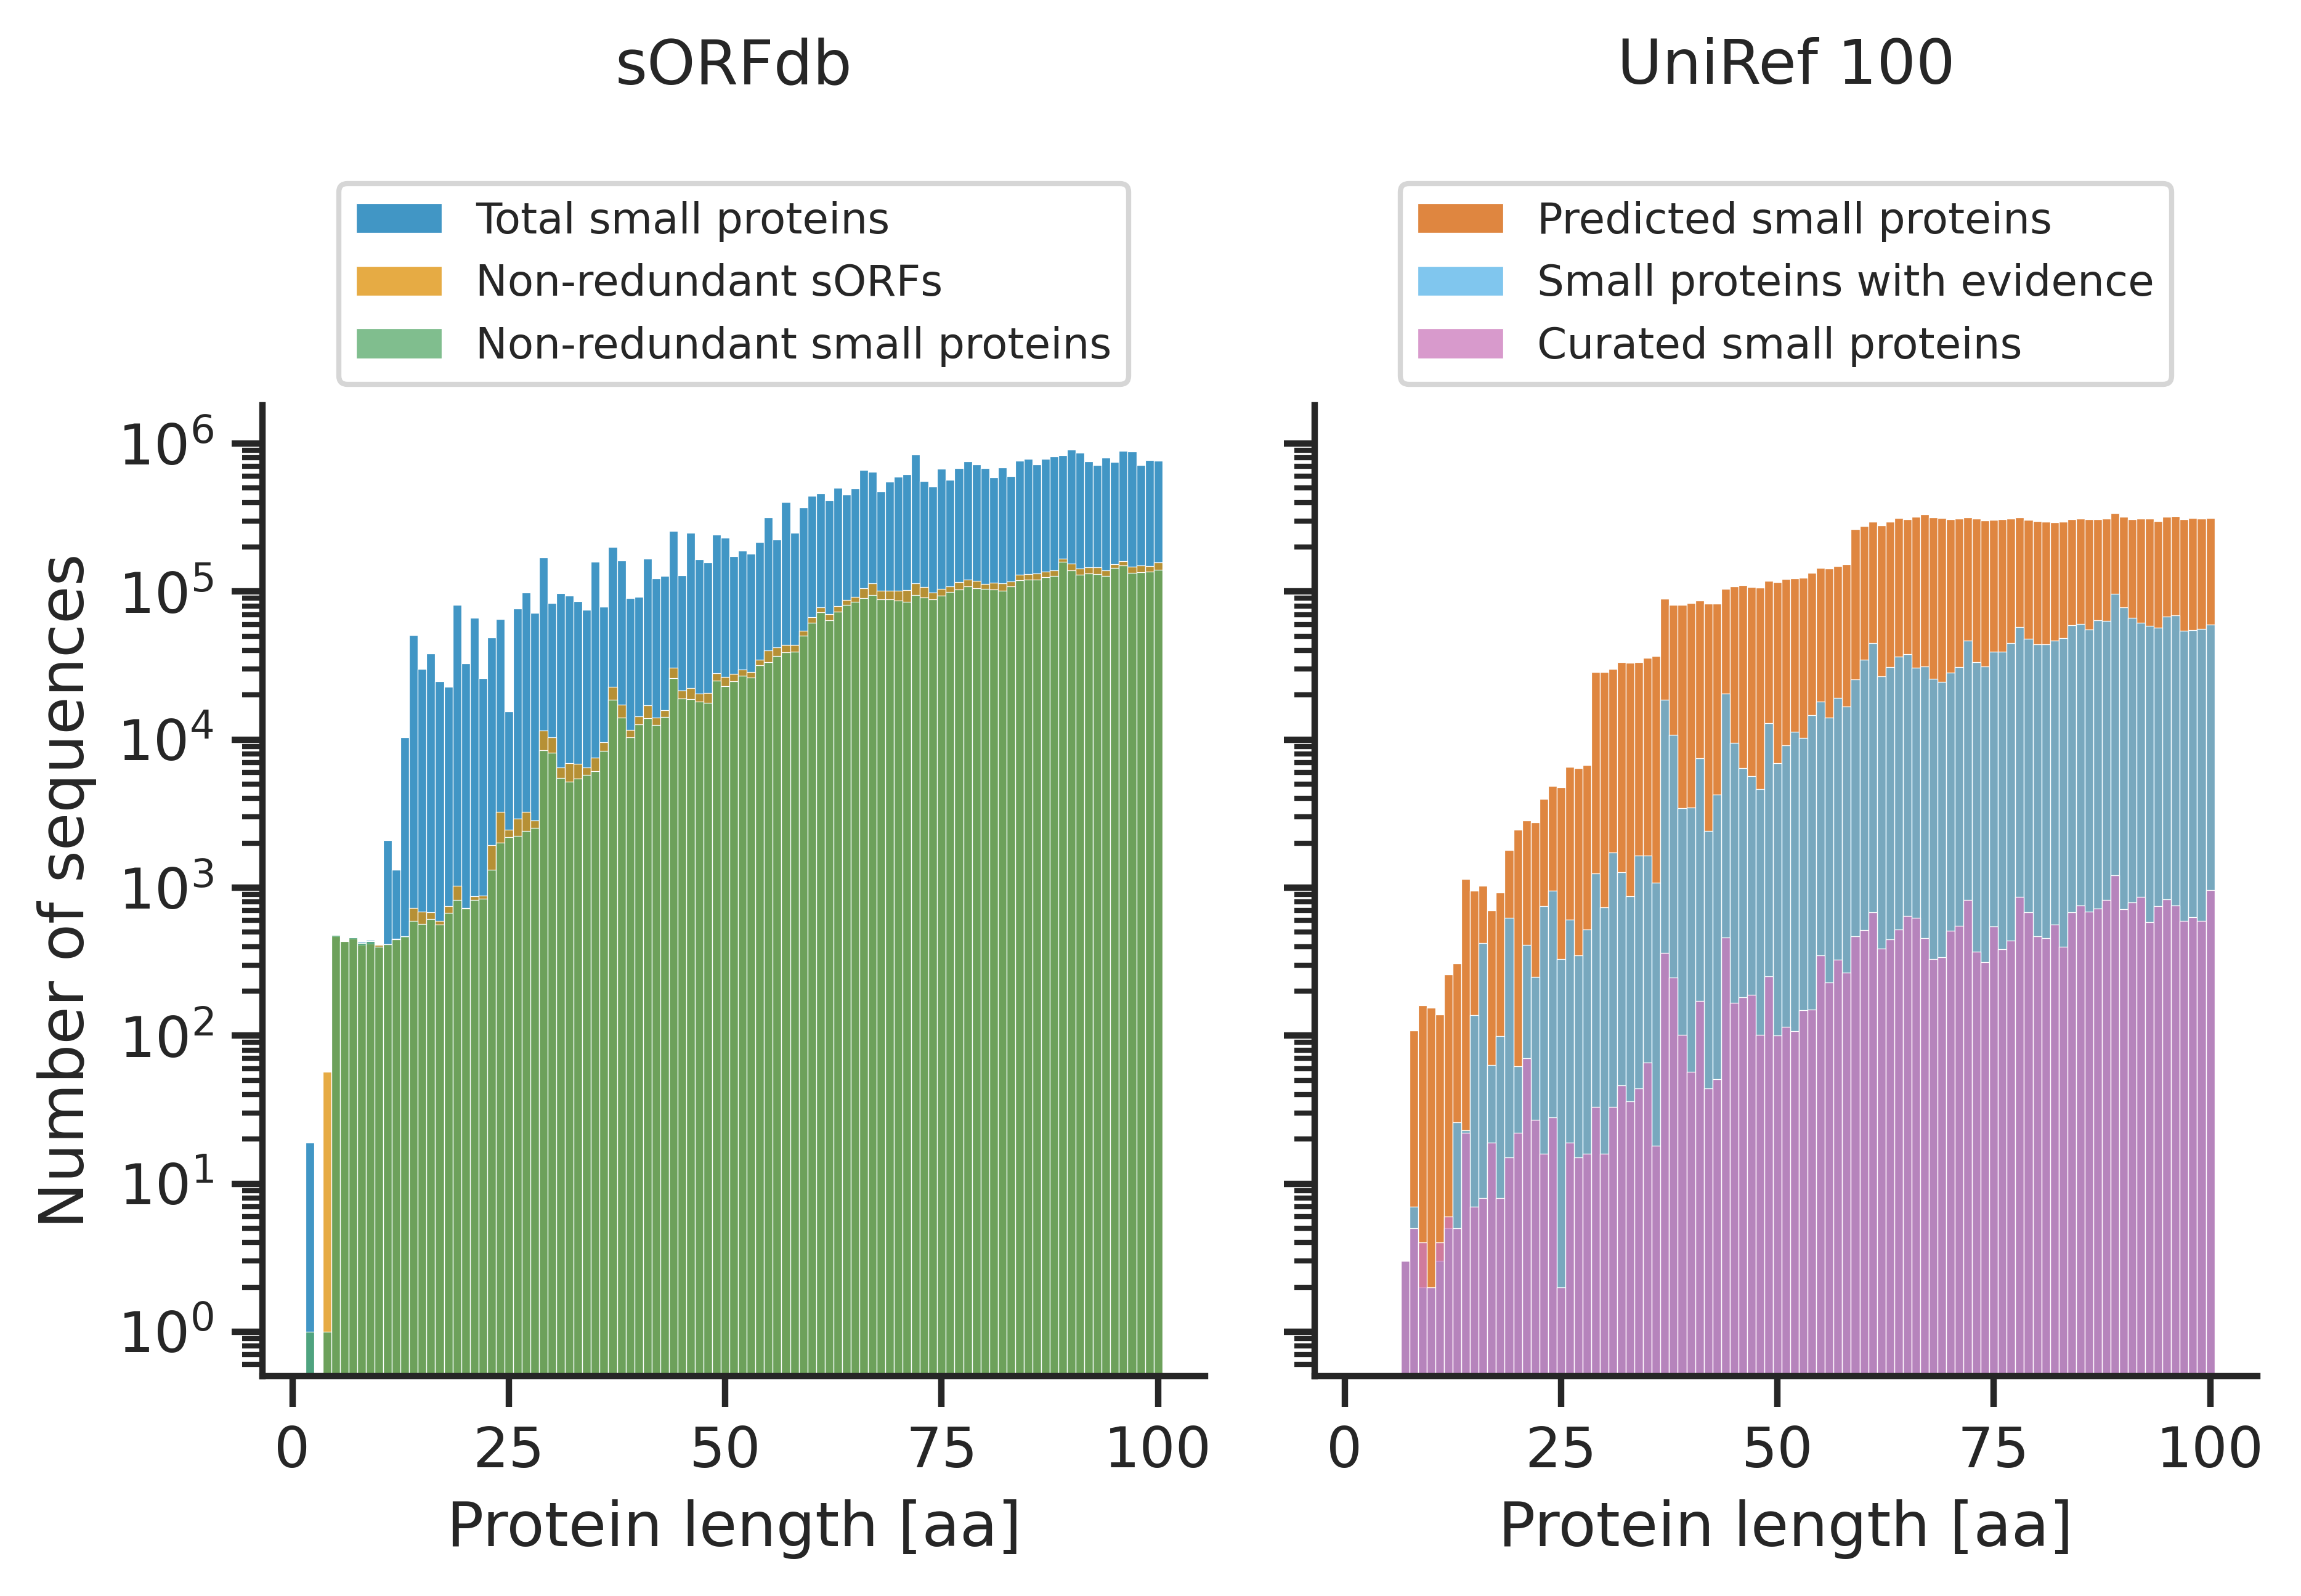

In [ ]:
combined_protein_length_plot(sprot_len_total, unique_sorf_len, unique_sprot_len, uniref100_swissport_len, uniref100_uniprot_filtered_len, uniref100_uniprot_all_len, args.output, group='100')

## Start codon usage

In [ ]:
def combined_start_codons(sub30: dict[str, int], sub50: dict[str, int], sub100: dict[str, int], plus100: dict[str, int], 
                          out_path: Path, file_name: str, group: str = ''):
    data = {'Length': [], 'x': [], 'y': []}
    
    for start_codon, label in zip((sub30, sub50, sub100), ('≤30aa', '≤50aa', '≤100aa')):
        
        n: int = sum([x for x in start_codon.values()])
        x: list[str] = []  # Start codons
        y: list[float] = []  # Percentage

        for codon, count in start_codon.items():
            percentage = count / n * 100
            if percentage > 0.1:
                x.append(codon)
                y.append(percentage)
        data['Length'].extend([label] * len(x))
        data['x'].extend(x)
        data['y'].extend(y)
        
    frame = pd.DataFrame.from_dict(data)

    bar = sns.barplot(data=frame, x='x', y='y', hue='Length')
    fig = plt.gcf()
    bar.set(title='Start codons {}'.format(group).rstrip(), xlabel='Codon', ylabel='Frequency')
    bar.set_ylim(0, 100)            
    fig.set_dpi(600.0)
    plt.savefig(str(out_path.joinpath(file_name)), bbox_inches="tight", dpi=600)

In [ ]:
#combined_start_codons(sub30=get_unique_start_codons([x for x in unique_orf if len(x) <= (30*3+3)]),
#                      sub50=get_unique_start_codons([x for x in unique_orf if (30*3+3) < len(x) <= (50*3+3)]), 
#                      sub100=get_unique_start_codons([x for x in unique_orf if len(x) > (50*3+3)]), 
#                      out_path=out_path, file_name='start_codon_all.png')

In [ ]:
def start_codons_1(df, out_path: Path, file_name: str, group: str = ''):
    
    bar = sns.barplot(data=df.to_pandas(), x='start', y='count', hue='Length [aa]', palette=sns.color_palette('colorblind'))
    
    #handles, labels = bar.get_legend_handles_labels()
    #print(labels)
    #labels = [(h, f'>={l}') for h, l in zip(handles, labels)]
    #print(labels)
    #bar.legend(*zip(*labels))  # , loc='upper left' , fontsize=10 , loc='lower center', bbox_to_anchor=(.5, 1)
    
    fig = plt.gcf()
    bar.set(xlabel='Start codon', ylabel='Frequency')
    fig.set_dpi(600.0)
    print(str(out_path.joinpath(file_name)))
    plt.savefig(str(out_path.joinpath(file_name)), bbox_inches="tight", dpi=600)

In [ ]:
def start_codons_2(df, out_path: Path, file_name: str, group: str = ''):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, width_ratios=(3, 7))
    f.set_dpi(600.0)
    
    bar1 = sns.barplot(ax=ax1, 
                      data=df.filter(pl.col('type') == 'canonical').to_pandas(), 
                      x='start', y='count', hue='Length [aa]', palette=sns.color_palette('colorblind'))
    bar1.get_legend().remove()
    bar1.set(xlabel='Canonical\nstart codon', ylabel='Frequency')
    
    bar2 = sns.barplot(ax=ax2, 
                      data=df.filter(pl.col('type') == 'non-canonical').to_pandas(), 
                      x='start', y='count', hue='Length [aa]', palette=sns.color_palette('colorblind'))
    bar2.set_ylim(bar1.get_ylim())
    bar2.set(xlabel='Non-canonical\nstart codon', ylabel=None, yticklabels=())
    bar2.tick_params(axis='y', which='both', length=0, right=False)
    
    handles, labels = bar2.get_legend_handles_labels()
    labels = [(h, f'≤{l}') for h, l in zip(handles, labels)]
    bar2.legend(*zip(*labels), title='Length [aa]', title_fontsize='small', fontsize='small')
    
    sns.despine(ax=bar1, right=True, top=False)
    sns.despine(ax=bar2, left=True, right=False, top=False)
    
    print(str(out_path.joinpath(file_name)))
    f.savefig(str(out_path.joinpath(file_name)), bbox_inches="tight", dpi=600)

In [ ]:
start_codon_df: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf'),
        pl.col('plen')
    ).drop_nulls().unique().select(
        pl.col('sorf').str.slice(0, length=3).alias('start'),
        pl.col('plen')
    ).select(
        pl.col('start'),
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).collect()

In [ ]:
#start_codon_df.with_columns(
#    pl.when(pl.col('start') == 'ATG')
#    .then(pl.lit('canonical'))
#    .when(pl.col('start') == 'TTG')
#    .then(pl.lit('canonical'))
#    .when(pl.col('start') == 'GTG')
#    .then(pl.lit('canonical'))
#    .otherwise(pl.lit('non-canonical')).alias('Start codon')
#).groupby(['Start codon', 'len']).count().groupby('len').apply(lambda x: x.select(
#    pl.col('Start codon'), pl.col('len'), (pl.col('count')/pl.col('count').sum())*100))

In [ ]:
#start_codon_df.groupby(['start', 'bin']).count().groupby('bin').apply(
#    lambda x: x.select(pl.col('start'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
#).groupby('start').agg(
#    pl.col('bin').filter(pl.col('count').sum() >= 1),
#    pl.col('count').filter(pl.col('count').sum() >= 1)
#).explode('bin', 'count').drop_nulls()

In [ ]:
#start_codons_1(
#    start_codon_df.groupby(['start', 'bin']).count()
#    .groupby('bin').apply(lambda x: x.select(
#        pl.col('start'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)).rename(
#        {'bin': 'Length [aa]'}
#    ), 
#    out_path=args.output, file_name='start_codon_all.png')

/vol/sorf/no_backup/db/sorfdb/raw/start_codon_all.pdf


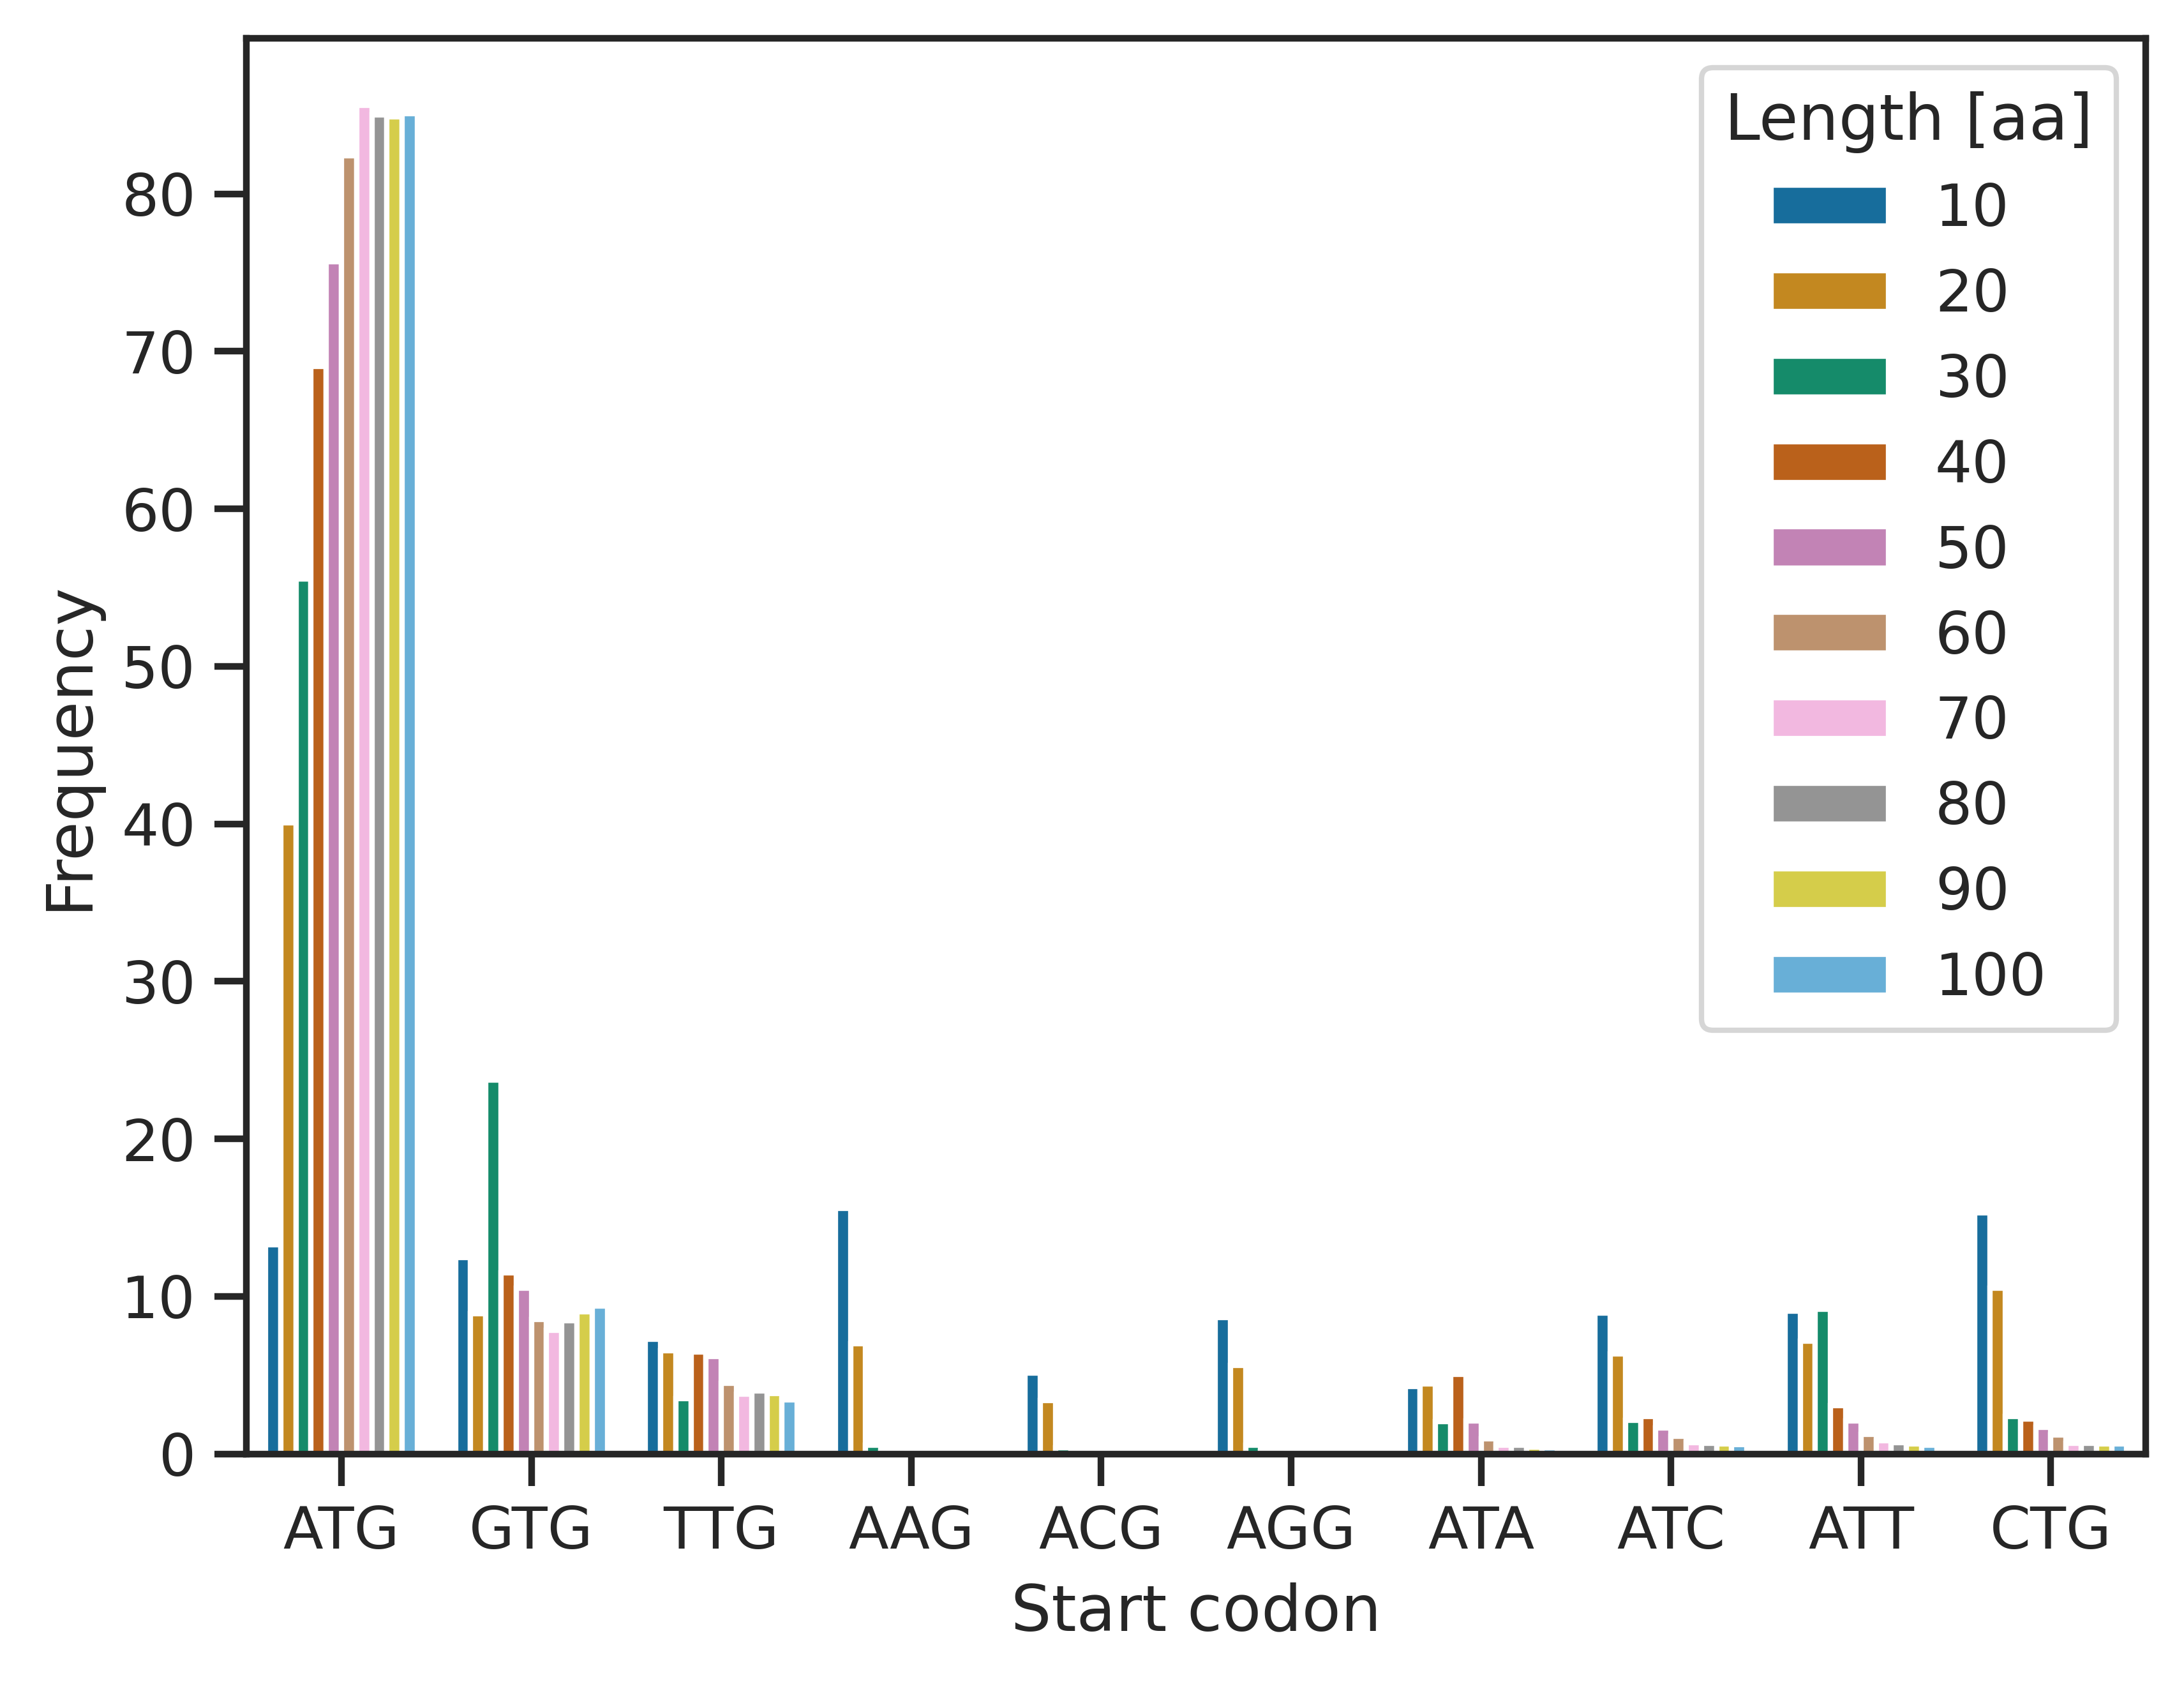

In [ ]:
start_codons_1(
    start_codon_df.groupby(['start', 'bin']).count().groupby('bin').apply(
        lambda x: x.select(pl.col('start'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
    ).groupby('start').agg(
        pl.col('bin').filter(pl.col('count').sum() >= 1),
        pl.col('count').filter(pl.col('count').sum() >= 1)
    ).explode('bin', 'count').drop_nulls().rename(
        {'bin': 'Length [aa]'}
    ).with_columns(
        pl.when(pl.col('start') == 'ATG')
        .then(pl.lit('canonical'))
        .when(pl.col('start') == 'TTG')
        .then(pl.lit('canonical'))
        .when(pl.col('start') == 'GTG')
        .then(pl.lit('canonical'))
        .otherwise(pl.lit('non-canonical')).alias('type')
    ).sort('type', 'start'), 
    out_path=args.output, file_name='start_codon_all.pdf')

/vol/sorf/no_backup/db/sorfdb/raw/start_codon_all2.pdf


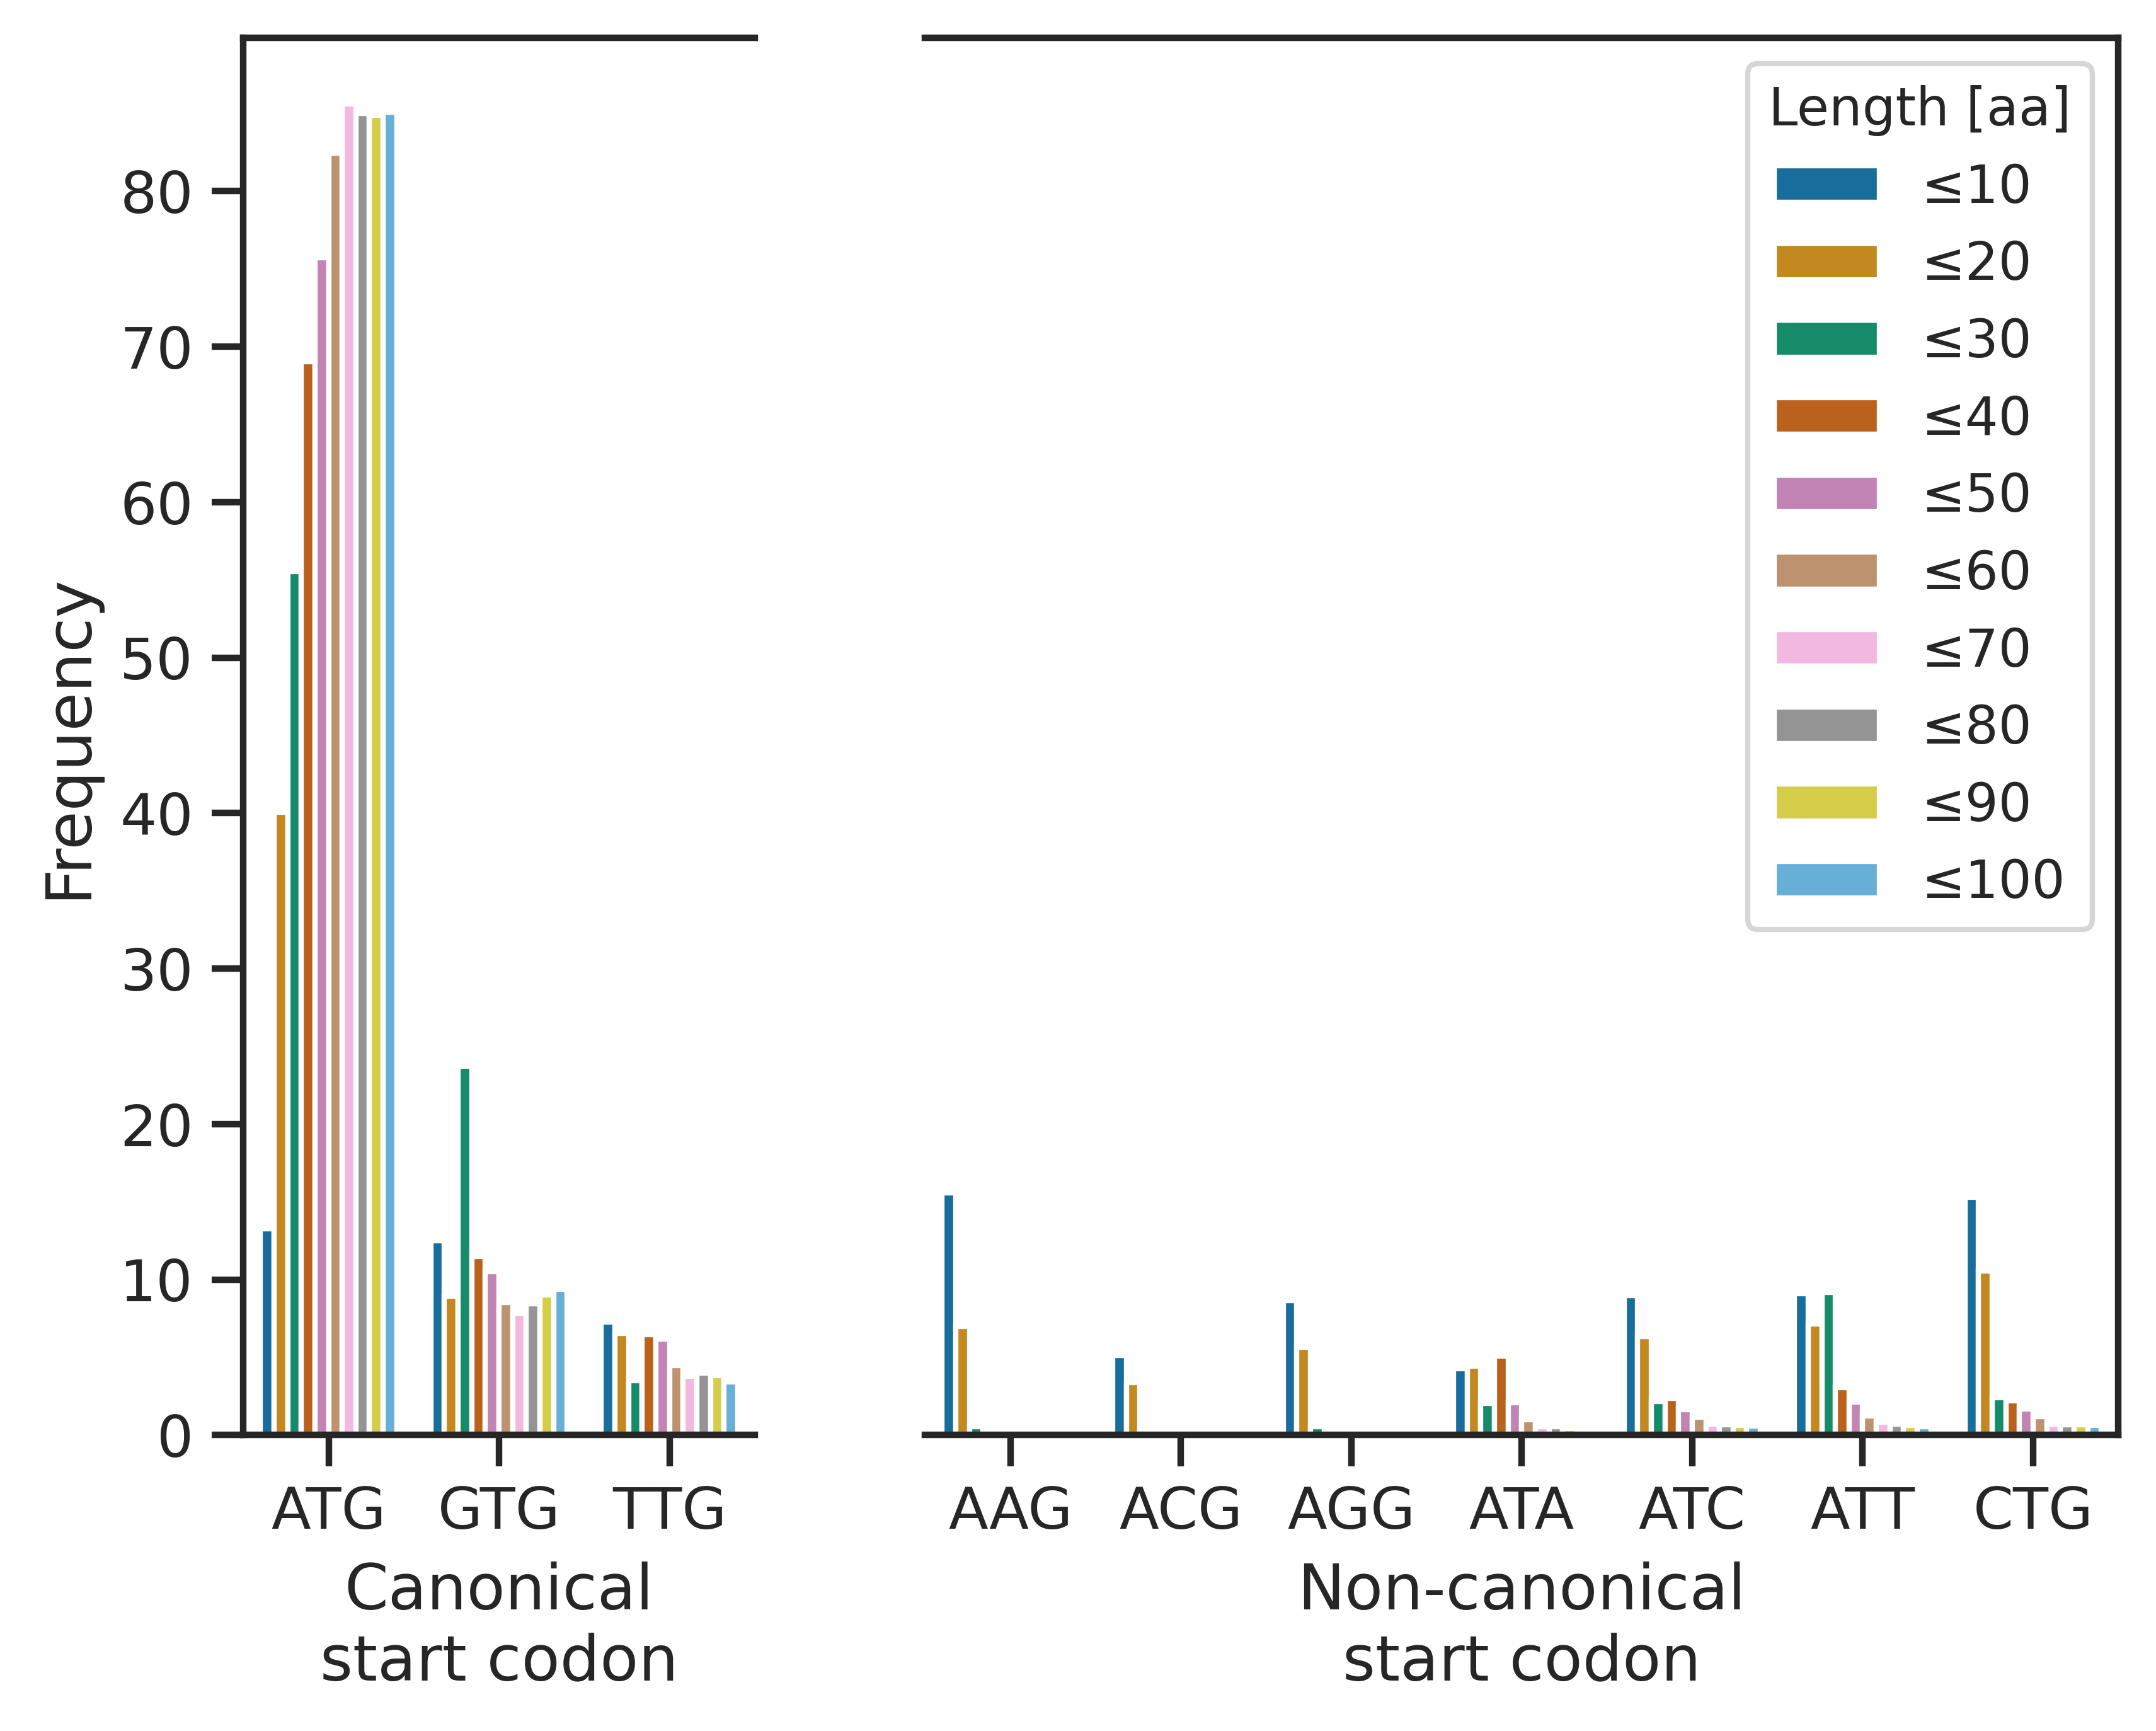

In [ ]:
start_codons_2(
    start_codon_df.groupby(['start', 'bin']).count().groupby('bin').apply(
        lambda x: x.select(pl.col('start'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
    ).groupby('start').agg(
        pl.col('bin').filter(pl.col('count').sum() >= 1),
        pl.col('count').filter(pl.col('count').sum() >= 1)
    ).explode('bin', 'count').drop_nulls().rename(
        {'bin': 'Length [aa]'}
    ).with_columns(
        pl.when(pl.col('start') == 'ATG')
        .then(pl.lit('canonical'))
        .when(pl.col('start') == 'TTG')
        .then(pl.lit('canonical'))
        .when(pl.col('start') == 'GTG')
        .then(pl.lit('canonical'))
        .otherwise(pl.lit('non-canonical')).alias('type')
    ).sort('type', 'start'), 
    out_path=args.output, file_name='start_codon_all2.pdf')

In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf'),
        pl.col('plen'),
        pl.col('phylum'),
        pl.col('class'),
        pl.col('order'),
        pl.col('family'),
        pl.col('genus')
    ).filter(
        (pl.col('plen') <= 20) & (pl.col('sorf').str.lengths() > 0)
    ).unique().with_columns(
        pl.col('sorf').str.slice(0, length=3).alias('start')
    ).with_columns(
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).select(
        pl.col('bin'),
        pl.col('len'),
        pl.col('start'),
        pl.col('phylum'),
        pl.col('class'),
        pl.col('order'),
        pl.col('family'),
        pl.col('genus')
    ).groupby(
        'phylum', 'class', 'order', 'family', 'genus'
    ).count().sort('count', descending=True).with_columns(
        (pl.col('count')/pl.col('count').sum()*100).round(2)
    ).collect().head(5)

phylum,class,order,family,genus,count
str,str,str,str,str,f64
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""",73.64
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Enterobacter""",2.15
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Salmonella""",2.08
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Citrobacter""",2.03
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Klebsiella/rao…",2.0


In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf'),
        pl.col('plen'),
        pl.col('phylum'),
        pl.col('class'),
        pl.col('order'),
        pl.col('family'),
        pl.col('genus')
    ).filter(
        (pl.col('plen') <= 10) & (pl.col('sorf').str.lengths() > 0)
    ).unique().with_columns(
        pl.col('sorf').str.slice(0, length=3).alias('start')
    ).with_columns(
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).select(
        pl.col('bin'),
        pl.col('len'),
        pl.col('start'),
        pl.col('phylum'),
        pl.col('class'),
        pl.col('order'),
        pl.col('family'),
        pl.col('genus')
    ).groupby(
        'phylum', 'class', 'order', 'family', 'genus'
    ).count().sort('count', descending=True).with_columns(
        (pl.col('count')/pl.col('count').sum()*100).round(2)
    ).collect().head(5)

phylum,class,order,family,genus,count
str,str,str,str,str,f64
"""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""",99.77
"""Bacillota""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""",0.08
"""Deinococcota""","""Deinococci""","""Deinococcales""","""Deinococcaceae…","""Deinococcus""",0.08
"""Bacillota""","""Bacilli""","""Lactobacillale…","""Lactobacillace…","""Leuconostoc""",0.04
"""Bacillota""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Cytobacillus""",0.04


In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf'),
        pl.col('plen'),
        pl.col('source')
    ).filter(
        (pl.col('plen') <= 20) & (pl.col('sorf').str.lengths() > 0)
    ).unique().with_columns(
        pl.col('sorf').str.slice(0, length=3).alias('start')
    ).with_columns(
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).select(
        pl.col('bin'),
        pl.col('len'),
        pl.col('start'),
        pl.col('source')
    ).groupby(
        'source'
    ).count().sort('count', descending=True).with_columns(
        (pl.col('count')/pl.col('count').sum()*100).round(2)
    ).collect()

source,count
str,f64
"""SmProt""",68.91
"""GenBank""",31.09


In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('sorf'),
        pl.col('plen'),
        pl.col('source')
    ).filter(
        (pl.col('plen') <= 10) & (pl.col('sorf').str.lengths() > 0)
    ).unique().with_columns(
        pl.col('sorf').str.slice(0, length=3).alias('start')
    ).with_columns(
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).select(
        pl.col('bin'),
        pl.col('len'),
        pl.col('start'),
        pl.col('source')
    ).groupby(
        'source'
    ).count().sort('count', descending=True).with_columns(
        (pl.col('count')/pl.col('count').sum()*100).round(2)
    ).collect()

source,count
str,f64
"""SmProt""",99.62
"""GenBank""",0.38


## RBS usage

In [ ]:
rbs_df_total: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('rbs'),
        pl.col('plen')
    ).drop_nulls().select(
        pl.col('rbs'),
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).collect().groupby(['rbs', 'bin']).count().groupby('bin').apply(
        lambda x: x.select(pl.col('rbs'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
).filter(pl.col('rbs') == 0).sort('bin').with_columns(pl.lit('total').alias('set'))

In [ ]:
rbs_df_unique: pl.DataFrame = pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('rbs'),
        pl.col('sorf'),
        pl.col('plen')
    ).unique().drop_nulls().select(
        pl.col('rbs'),
        pl.col('plen').alias('len'),
        ((((pl.col("plen") - 1) // 10) * 10) + 10).alias('bin')
    ).collect().groupby(['rbs', 'bin']).count().groupby('bin').apply(
        lambda x: x.select(pl.col('rbs'), pl.col('bin'), (pl.col('count')/pl.col('count').sum())*100)
    ).filter(pl.col('rbs') == 0).sort('bin').with_columns(pl.lit('total').alias('set'))

In [ ]:
pl.scan_csv(
        args.sorfdb,
        separator='\t'
    ).select(
        pl.col('rbs'),
        pl.col('sorf'),
    ).unique().drop_nulls().groupby('rbs').count().select(
        pl.col('rbs'),
        pl.col('count')/pl.col('count').sum()*100
    ).collect()

rbs,count
i64,f64
0,26.167605
1,73.832395


In [ ]:
#print(rbs_df_total)
print(rbs_df_unique)

shape: (10, 4)
┌─────┬─────┬───────────┬───────┐
│ rbs ┆ bin ┆ count     ┆ set   │
│ --- ┆ --- ┆ ---       ┆ ---   │
│ i64 ┆ i64 ┆ f64       ┆ str   │
╞═════╪═════╪═══════════╪═══════╡
│ 0   ┆ 10  ┆ 100.0     ┆ total │
│ 0   ┆ 20  ┆ 87.474048 ┆ total │
│ 0   ┆ 30  ┆ 61.25261  ┆ total │
│ 0   ┆ 40  ┆ 56.153047 ┆ total │
│ …   ┆ …   ┆ …         ┆ …     │
│ 0   ┆ 70  ┆ 23.733212 ┆ total │
│ 0   ┆ 80  ┆ 24.689411 ┆ total │
│ 0   ┆ 90  ┆ 23.713169 ┆ total │
│ 0   ┆ 100 ┆ 24.379174 ┆ total │
└─────┴─────┴───────────┴───────┘


In [ ]:
def rbs_1(df, out_path: Path, file_name: str, group: str = ''):
    
    bar = sns.barplot(data=df.to_pandas(), x='rbs', y='count', hue='Length [aa]', palette=sns.color_palette('colorblind'))
    
    handles, labels = bar.get_legend_handles_labels()
    labels = [(h, f'≤{l}') for h, l in zip(handles, labels)]
    bar.legend(*zip(*labels), title='Length [aa]', title_fontsize='small', fontsize='small')
    
    fig = plt.gcf()
    bar.set(xlabel='sORF sequences without detected RBS', ylabel='Frequency')
    fig.set_dpi(600.0)
    print(str(out_path.joinpath(file_name)))
    plt.savefig(str(out_path.joinpath(file_name)), bbox_inches="tight", dpi=600)

In [ ]:
#rbs_1(rbs_df_total.with_columns(
#        pl.col('rbs').map_dict(
#            {0: 'None detected', 1: 'Detected'}
#        )).rename({'bin': 'Length [aa]'}),
#      out_path=args.output, file_name='rbs_all_total.svg')

/vol/sorf/no_backup/db/sorfdb/raw/rbs_all_unique.pdf


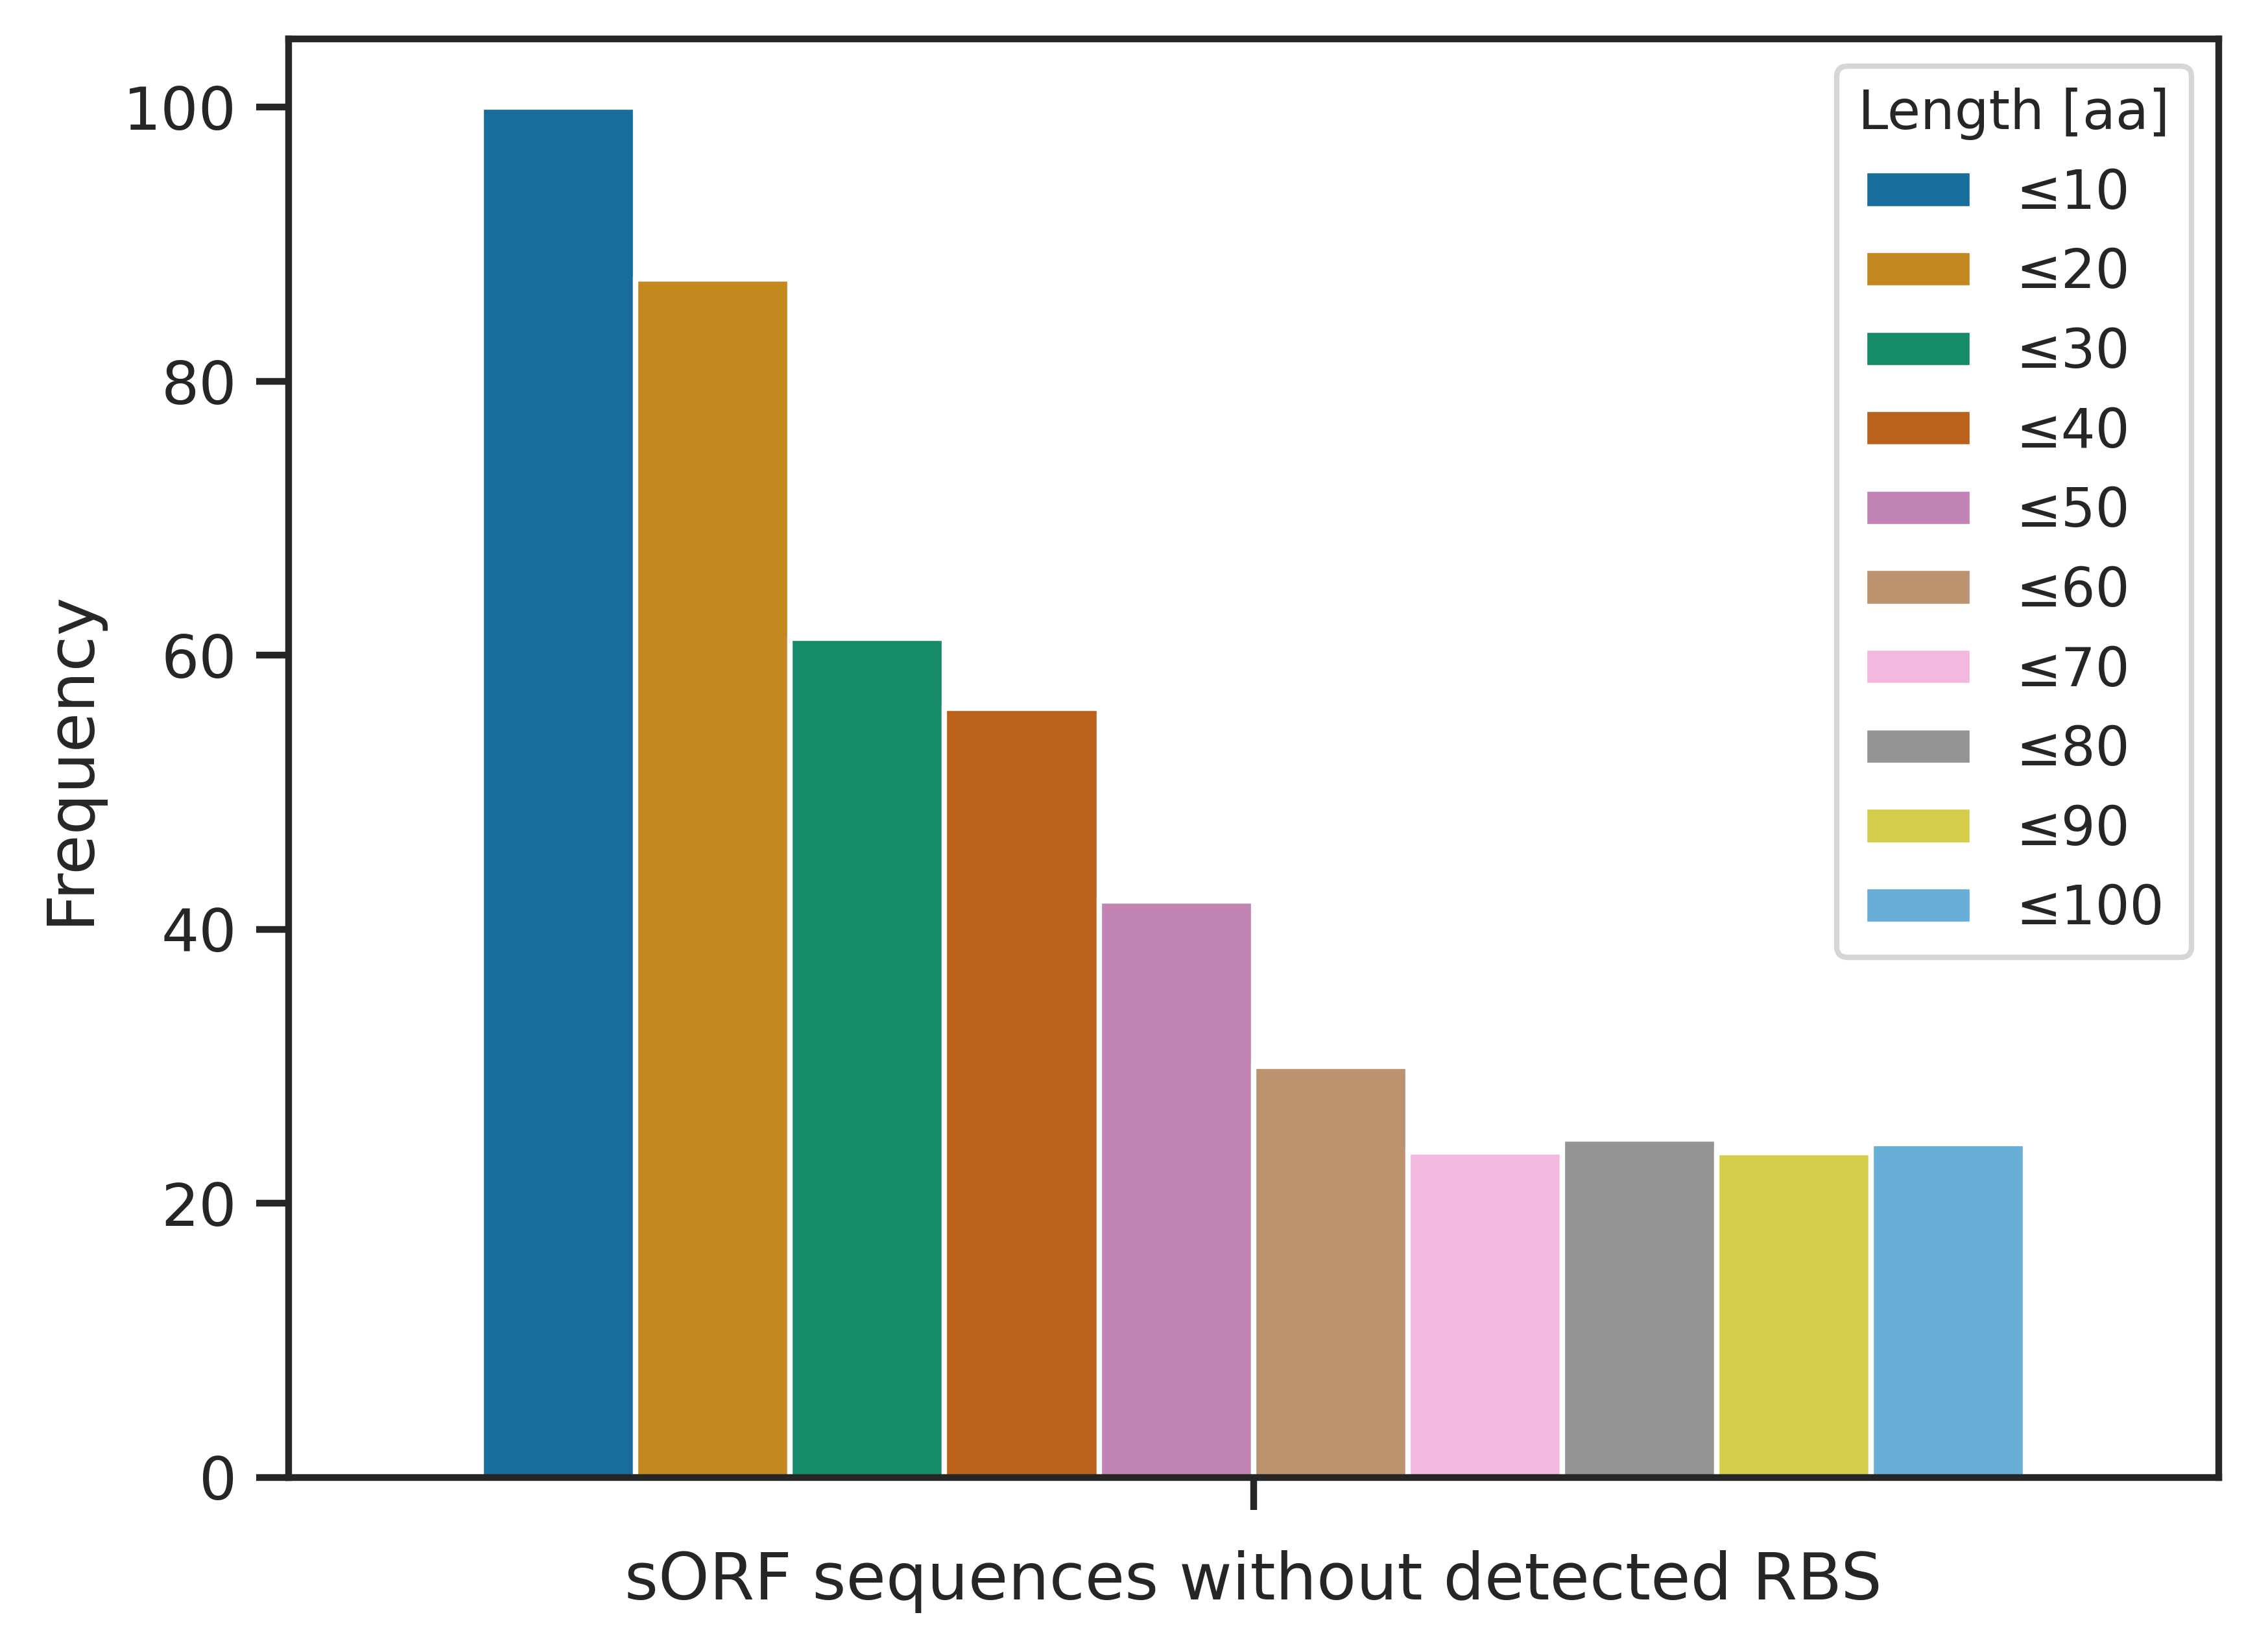

In [ ]:
rbs_1(rbs_df_unique.with_columns(
pl.col('rbs').map_dict(
            {0: '', 1: 'sORF sequences with detected RBS'}
        )).rename({'bin': 'Length [aa]'}),
      out_path=args.output, file_name='rbs_all_unique.pdf')

# Taxonomy

In [ ]:
def load_taxonomy(db_path: Path) -> pl.DataFrame:
    compressed: bool = str(db_path).endswith('.gz')
    opener: Union[pl.read_csv, pl.scan_csv]
    if compressed:
        opener = pl.read_csv
    else:
        opener = pl.scan_csv

    db_df: Union[pl.DataFrame, pl.LazyFrame]
    db_df = opener(
        db_path,
        separator='\t'
    ).select(
        pl.col('protein'),
        pl.col('phylum'),
        pl.col('class'),
        pl.col('order'),
        pl.col('family'),
        pl.col('genus'),
        pl.col('species'),
    ).filter(
        pl.col('protein').str.lengths() <= const.HMM_MAX_SPROT_LENGTH
    ).unique()
    
    if compressed:
        return db_df
    return db_df.collect()

In [ ]:
taxonomy: pl.DataFrame = load_taxonomy(args.sorfdb)

In [ ]:
family_taxonomy: pl.DataFrame = taxonomy.filter(
    pl.col('protein').is_in(protein_families.select('protein').to_series())
)

singleton_taxonomy: pl.DataFrame = taxonomy.filter(
    pl.col('protein').is_in(clusters.groupby('cluster').agg(
        [pl.col('protein'),
         pl.col('cluster').count().alias('count')]
    ).filter(
        pl.col('count') == 1
    ).select(
        pl.col('protein'),
        pl.col('cluster')
    ).explode(pl.col('protein')).select('protein').to_series())
)

In [ ]:
family_taxonomy

protein,phylum,class,order,family,genus,species
str,str,str,str,str,str,str
"""MKQHKAMIVALIVI…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MSLVLCFLLMSLFF…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MSAGVITGVLLVFL…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MRLSANRQGNTCAG…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""METFCYMKWPVRHH…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MFSKLAQSSIKAMF…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MEIKVQRLSLWMIN…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MTLAQFAMIFWHDL…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
"""MTKHPTGIYVGCLV…","""Pseudomonadota…","""Gammaproteobac…","""Enterobacteral…","""Enterobacteria…","""Escherichia""","""Escherichia co…"
